In [84]:
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta, tzinfo
import pandas as pd
import fluxy as fl
from itertools import product

from analysis.analysis_functions import AC_power, compound_variables, hub_variables, grid_power, get_data, kwh_meters_rename_dict, electrical_groups_dict_inv, electrical_consumption_groups_dict_inv, electrical_consumption_groups

%load_ext autoreload 
%autoreload 2

load_dotenv()

API_TOKEN = os.getenv("ANALYSIS_API_TOKEN")

import matplotlib.pylab as plt 
import seaborn as sns 

sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
start = datetime(2024,8,22,  tzinfo = timezone.utc) - timedelta(hours = 3)
stop = datetime(2024,10,22,  tzinfo = timezone.utc) - timedelta(hours = 3)
window_size = timedelta(days = 1)

end_of_no_events = '2024-09-14 02:00:00+02:00'
start_of_events = '2024-09-15 02:00:00+02:00'

In [56]:
consumers_variables = [*compound_variables, *hub_variables]

compound_data = await get_data(
    [{"_field": variable} for variable in compound_variables],
    (start, stop),
    window_size,
    fl.WindowOperation.MEAN,
    API_TOKEN,
)


compound_data.index = compound_data.index.tz_convert("Europe/Madrid")

compound_data = compound_data.rename(
    columns=kwh_meters_rename_dict
)  # fix wrong naming in databases


In [61]:
consumers_kwh = consumers_data.T.groupby(electrical_consumption_groups_dict_inv).sum().T*24/1000
functional_consumption_groups = {"office":"office", "workshop":"workshop","simulator":"simulator","kitchen_sanitary_1":"sanitary","kitchen_sanitary_2":"catering","center_1":"catering", "center_2":"events"}
groups_kwh = consumers_kwh.T.groupby(functional_consumption_groups).sum().T


Text(0.5, 1.0, 'No events \nAverage daily energy use of 17 kWh')

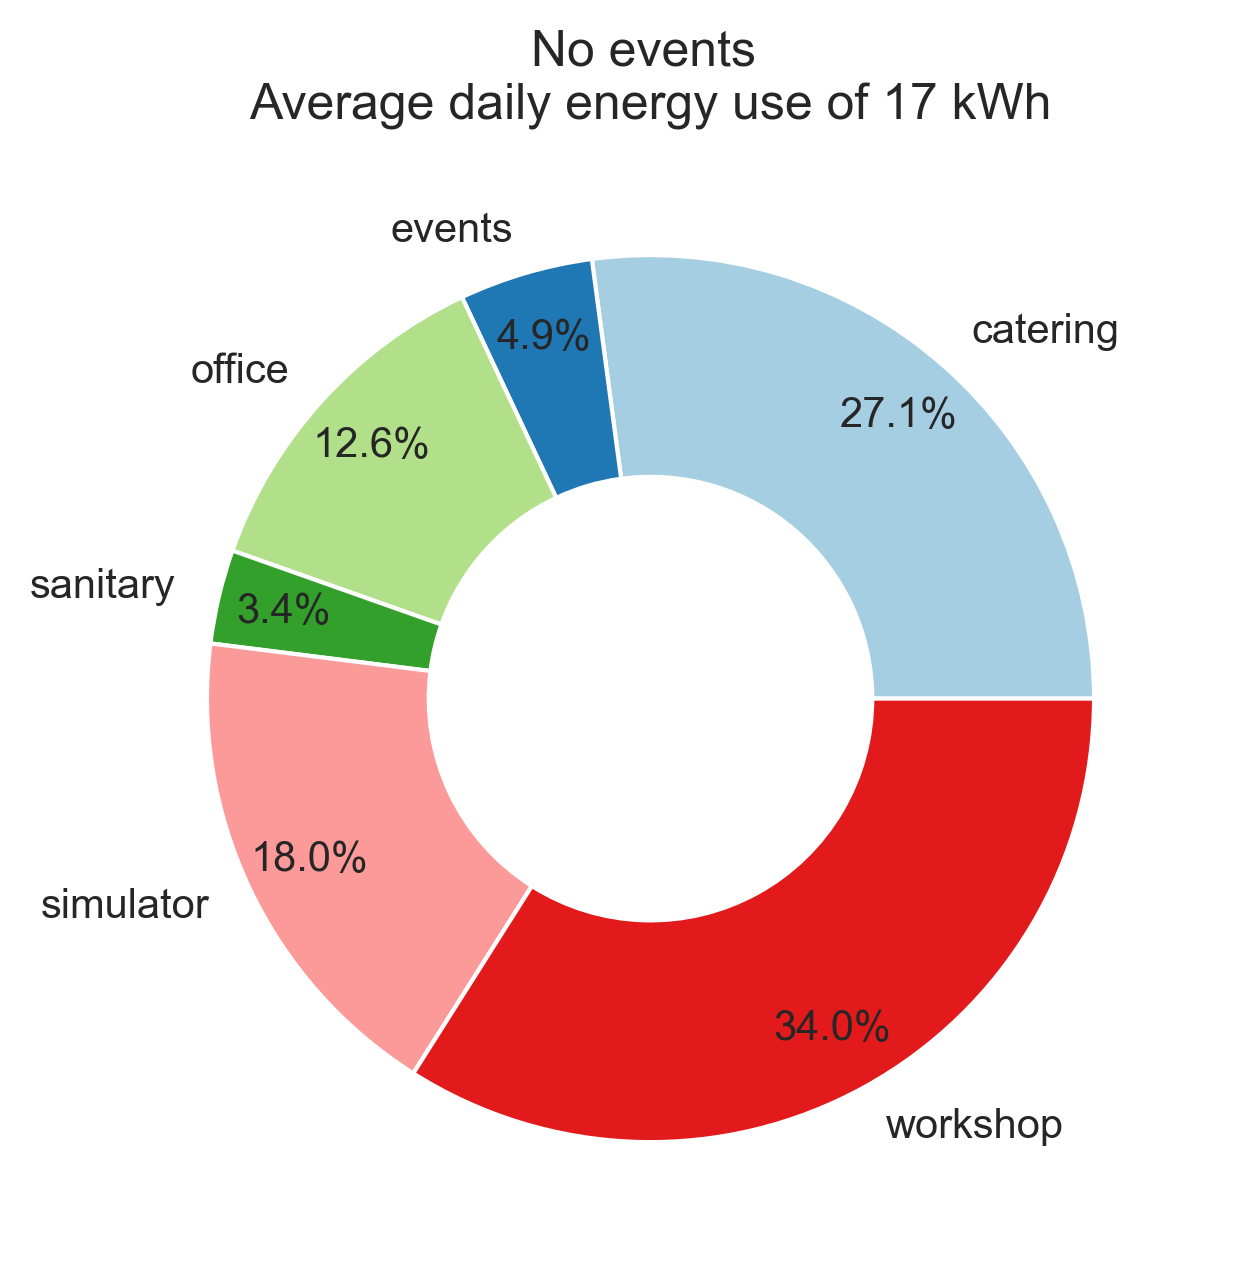

In [66]:
df = groups.loc[:end_of_no_events].mean()
label = 'No events'

fig, ax = plt.subplots(dpi = 300)
ax.pie(df, labels=df.index, autopct='%1.1f%%', wedgeprops=dict(width=0.5), pctdistance=0.85, colors = sns.color_palette("Paired"))
plt.title(f'{label} \nAverage daily energy use of {df.sum():.0f} kWh')

Text(0.5, 1.0, 'With events \nAverage daily energy use of 39 kWh')

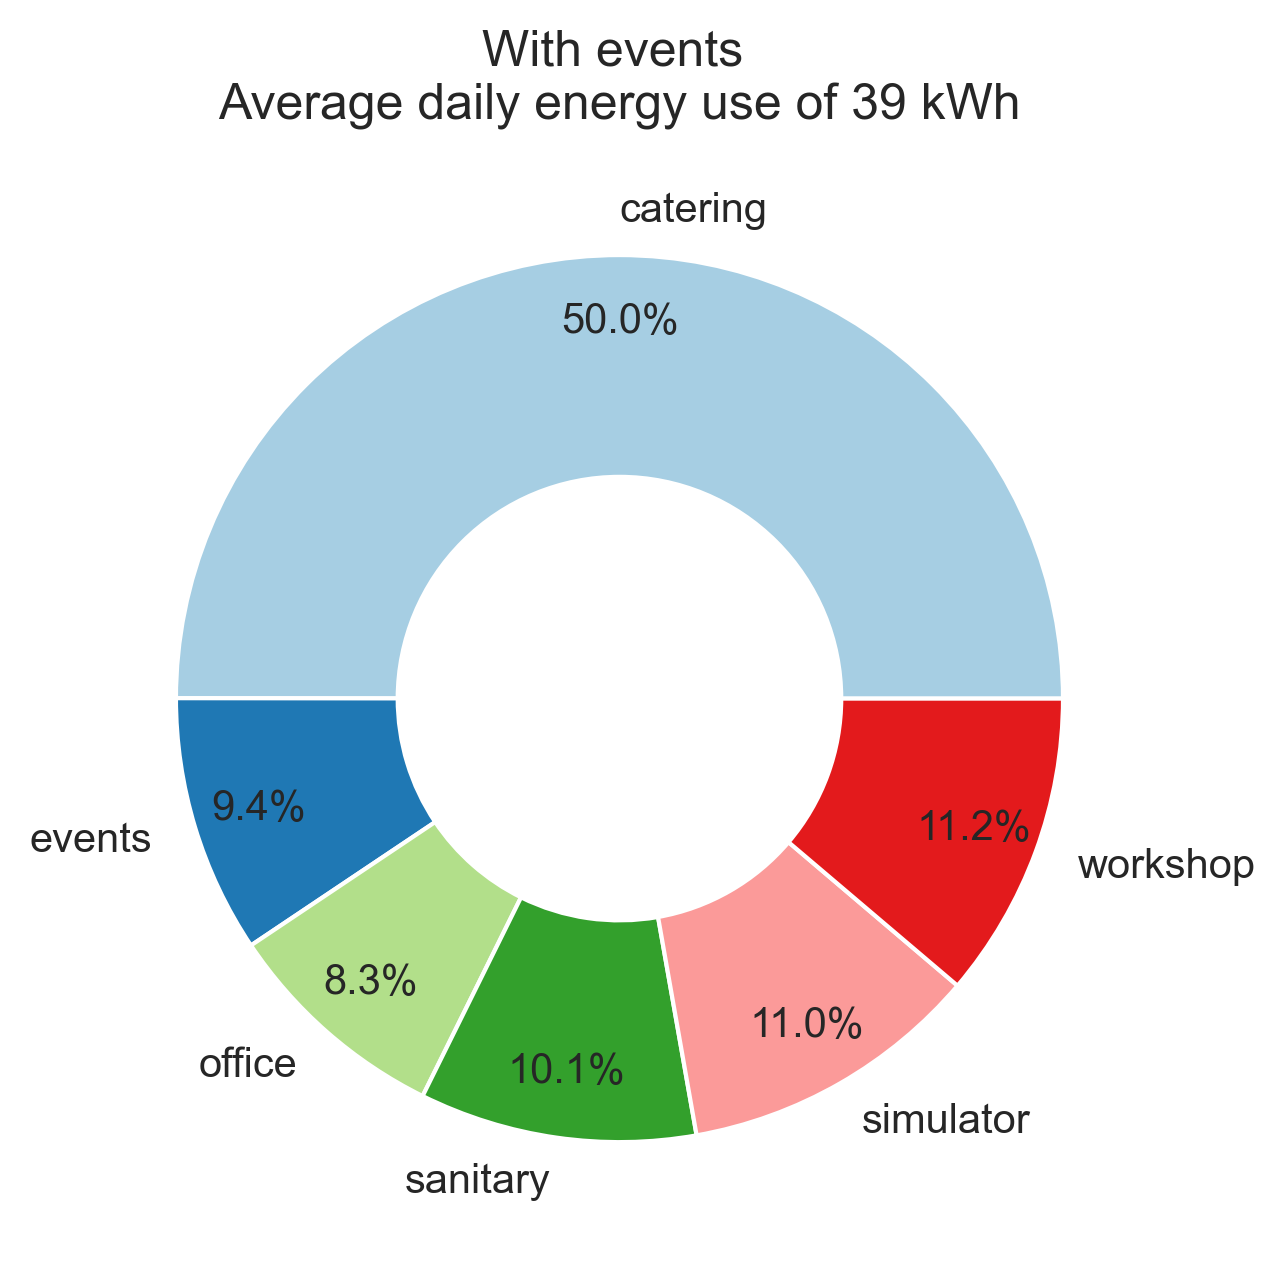

In [165]:
df = groups.loc[start_of_events:].mean()
label = 'With events'

fig, ax = plt.subplots(dpi = 300)
ax.pie(df, labels=df.index, autopct='%1.1f%%', wedgeprops=dict(width=0.5), pctdistance=0.85, colors = sns.color_palette("Paired"))
plt.title(f'{label} \nAverage daily energy use of {df.sum():.0f} kWh')

In [85]:
aggregate_variables = ["electrical_pv_power", *grid_power, *AC_power]

aggregate_data = await get_data(
    [{"_field": variable} for variable in aggregate_variables],
    (start, stop),
    window_size,
    fl.WindowOperation.MEAN,
    API_TOKEN,
)


aggregate_data.index = aggregate_data.index.tz_convert("Europe/Madrid")

In [86]:
aggregate_kwh = aggregate_data.T.groupby(electrical_groups_dict_inv).sum().T.rename(columns = {'grid_power':'grid','pv_power':'pv', 'AC_power':'consumption'})*24/1000

In [99]:
aggregate_kwh = aggregate_kwh.drop('2024-09-24 02:00:00+02:00', axis = 0)  #drop faulty AC consumption 

In [174]:
aggregate_kwh.describe()

,consumption,grid,pv
count,61.000000,61.000000,61.000000
mean,98.470956,17.125403,119.553371
std,42.980702,26.992596,58.810702
min,0.000000,0.000000,0.022518
25%,74.497675,0.000000,88.529876
50%,103.548341,0.000000,128.966529
75%,127.459837,29.155436,157.917342
max,201.300000,107.491542,278.635771


<Axes: xlabel='_time'>

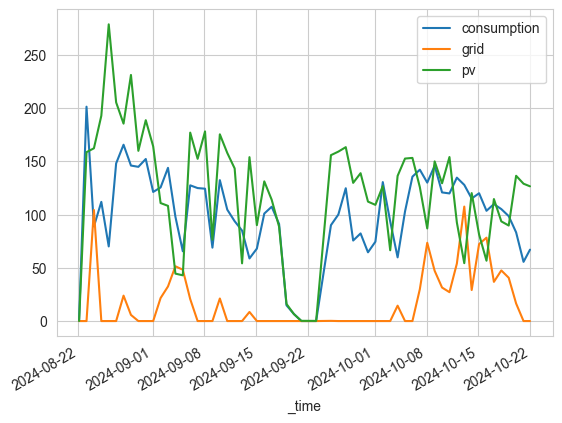

In [153]:
aggregate_kwh.plot()

In [134]:
soc_data = await get_data(
    [{"_field":"electrical_battery_system_soc"}],
    (start, stop),
    timedelta(hours = 1),
    fl.WindowOperation.LAST,
    API_TOKEN,
)

In [135]:
soc_data = soc_data.assign(no_event = soc_data.loc[:end_of_no_events]['electrical_battery_system_soc'],
                with_event = soc_data.loc[start_of_events:]['electrical_battery_system_soc']).drop(columns = 'electrical_battery_system_soc')



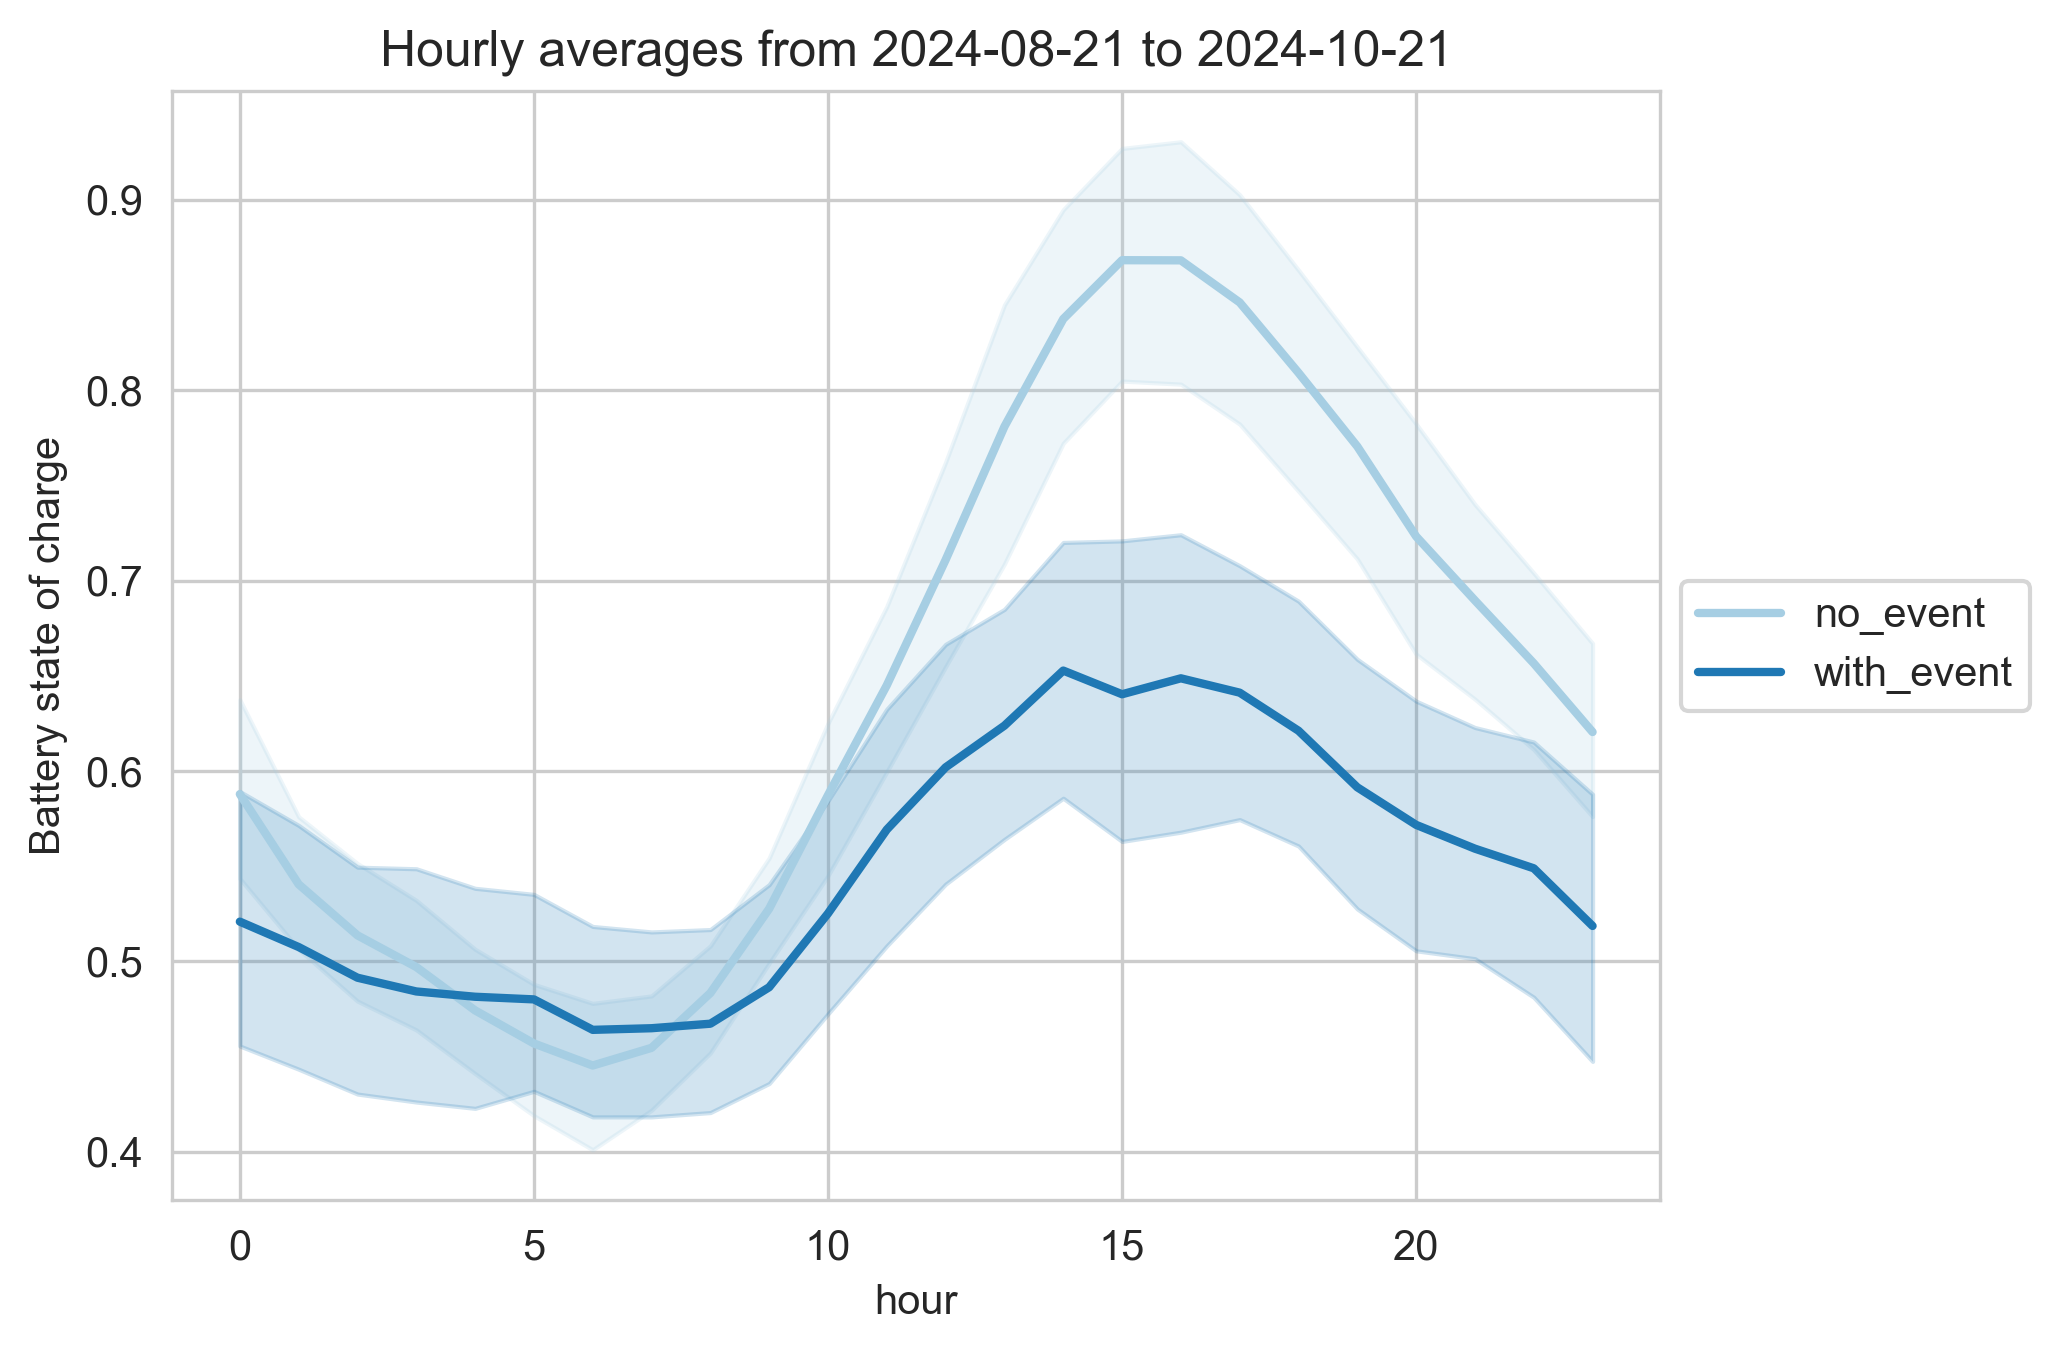

In [136]:
plot_hourly_avg(soc_data, 'Battery state of charge')

In [138]:
start = datetime(2024,8,22,  tzinfo = timezone.utc) - timedelta(hours = 3)
stop = datetime(2024,10,22,  tzinfo = timezone.utc) - timedelta(hours = 3)
window_size = timedelta(days = 1)

cooling_supply = await get_data([{"_field": var} for var in ["cold_reservoir_cooling_supply","weather_ambient_temperature"]], (start, stop), window_size, fl.WindowOperation.MEAN, API_TOKEN)

<Axes: xlabel='_time'>

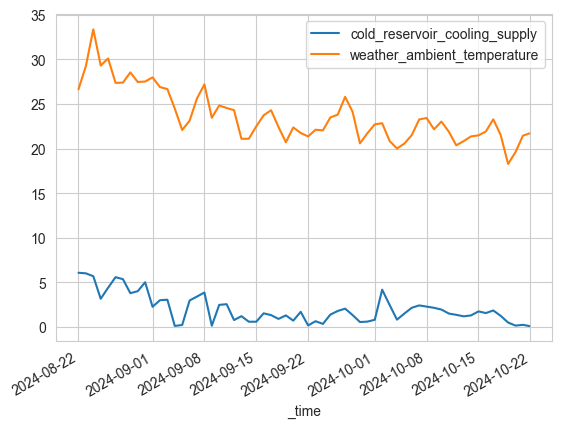

In [156]:
cooling_supply['cold_reservoir_cooling_supply'] = cooling_supply['cold_reservoir_cooling_supply']/1000
cooling_supply.plot()

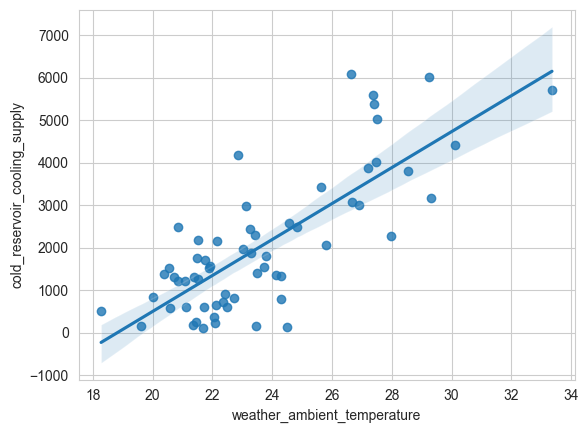

In [141]:
sns.regplot(x="weather_ambient_temperature", y="cold_reservoir_cooling_supply", data=cooling_supply);

In [145]:
from scipy import stats
slope, intercept, r, p, std_err = stats.linregress(cooling_supply['weather_ambient_temperature'], cooling_supply['cold_reservoir_cooling_supply']/1000)

In [150]:
slope

0.42289320011450454

In [163]:
volume_variables = [
    "fresh_to_kitchen_flow_sensor_total_volume",
    "technical_to_wash_off_flow_sensor_total_volume",
    "technical_to_sanitary_flow_sensor_total_volume"
]

volumes_data = await get_data([{"_field": variable} for variable in volume_variables], (start, stop), window_size, fl.WindowOperation.LAST, API_TOKEN)
volumes_data.index = volumes_data.index.tz_convert('Europe/Madrid')

daily_liters = volumes_data.diff().rename(columns = {"fresh_to_kitchen_flow_sensor_total_volume":"kitchen water",
    "technical_to_wash_off_flow_sensor_total_volume":"wash off water",
    "technical_to_sanitary_flow_sensor_total_volume":"sanitary water"})*1000

Text(0.5, 1.0, 'No events \nAverage daily water use of 321 l')

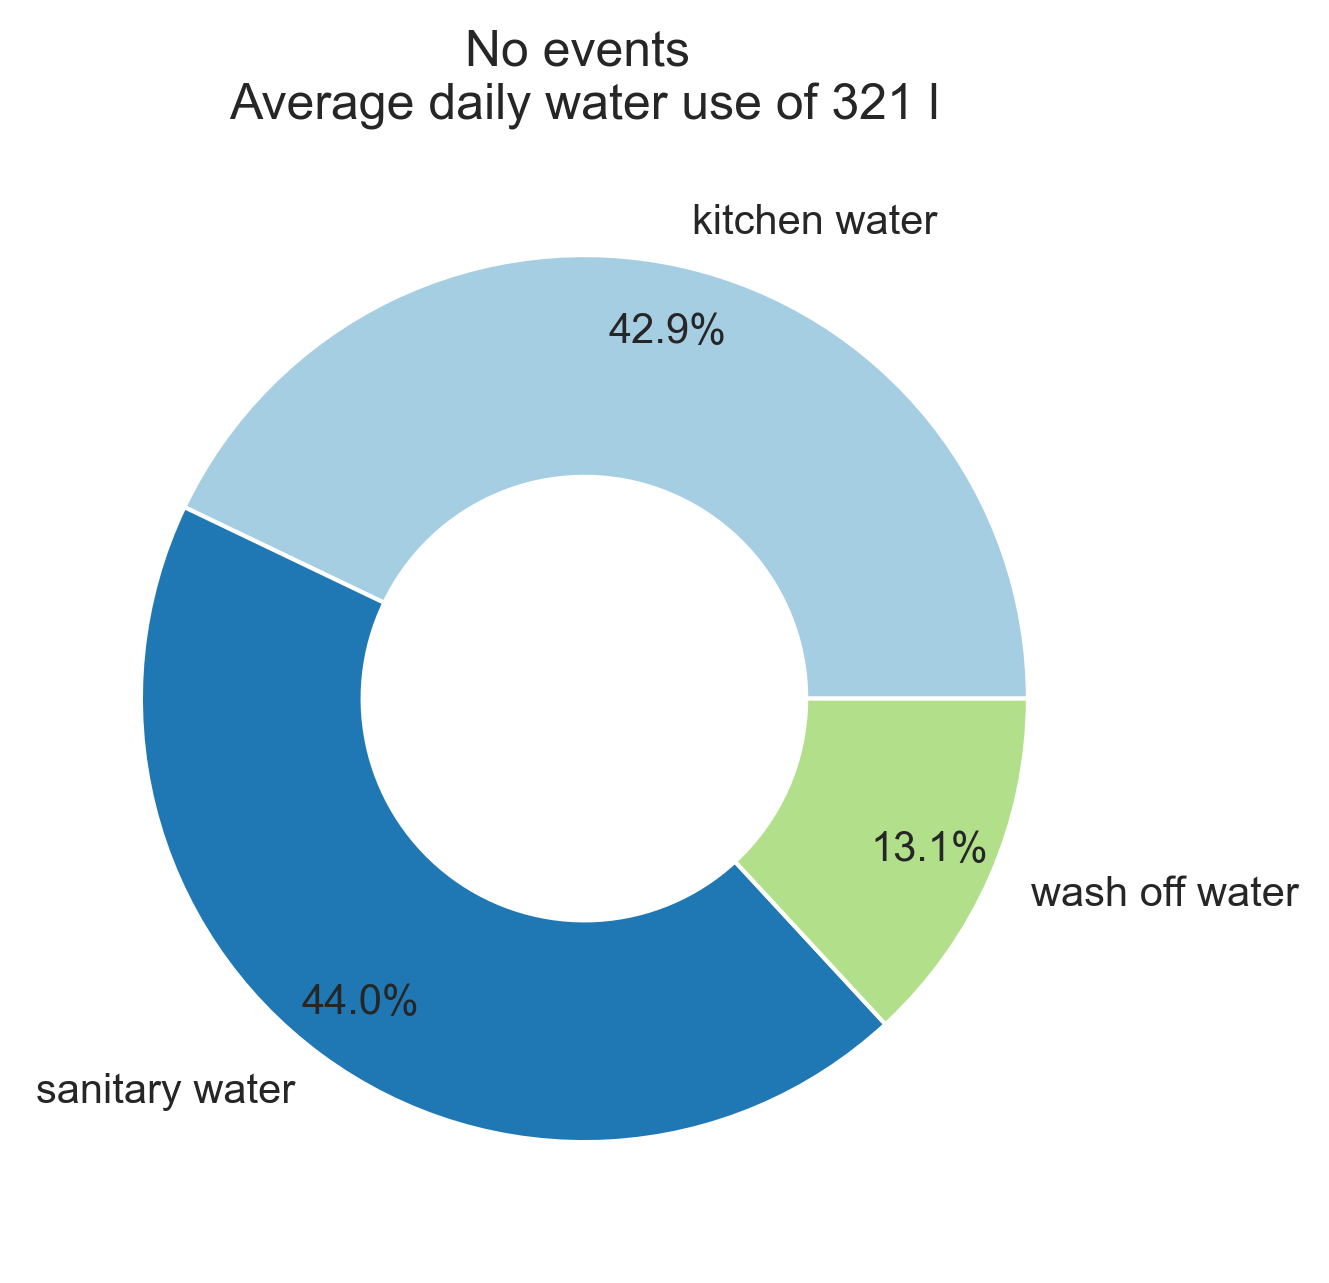

In [167]:
df = daily_liters.loc[:end_of_no_events].mean()
label = 'No events'

fig, ax = plt.subplots(dpi = 300)
ax.pie(df, labels=df.index, autopct='%1.1f%%', wedgeprops=dict(width=0.5), pctdistance=0.85, colors = sns.color_palette("Paired"))
plt.title(f'{label} \nAverage daily water use of {df.sum():.0f} l')

Text(0.5, 1.0, 'With events \nAverage daily water use of 566 l')

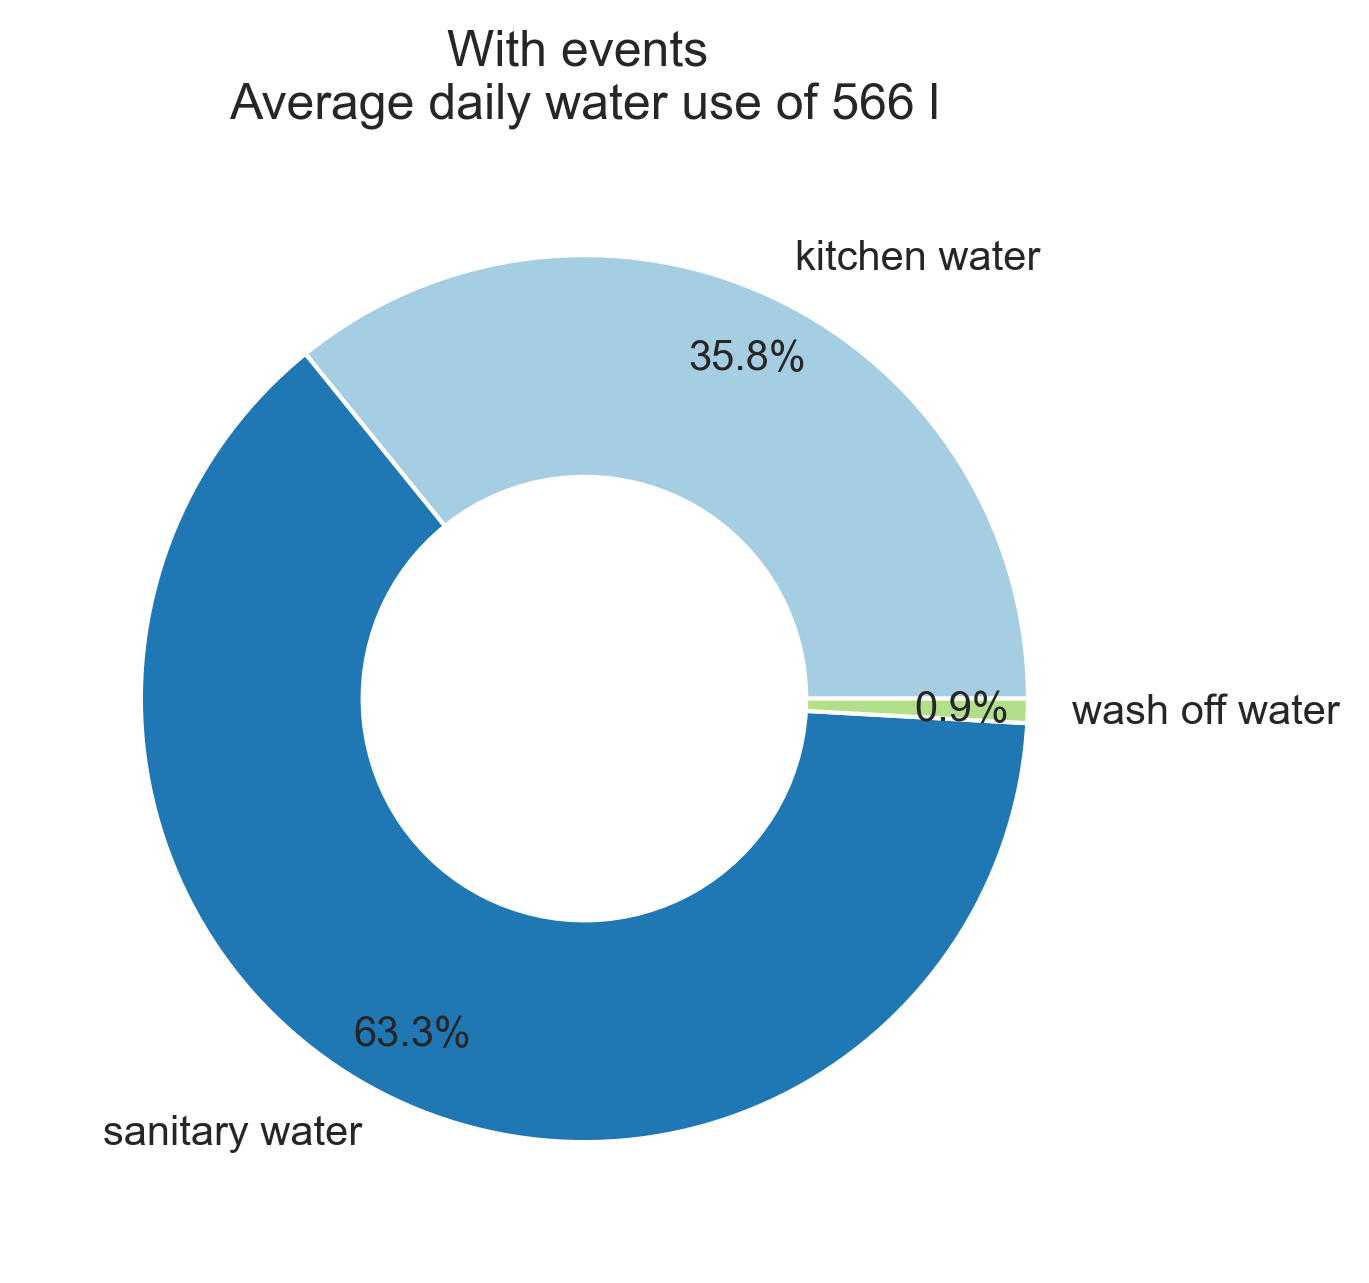

In [169]:
df = daily_liters.loc[start_of_events:].mean()
label = 'With events'

fig, ax = plt.subplots(dpi = 300)
ax.pie(df, labels=df.index, autopct='%1.1f%%', wedgeprops=dict(width=0.5), pctdistance=0.85, colors = sns.color_palette("Paired"))
plt.title(f'{label} \nAverage daily water use of {df.sum():.0f} l')